In [1]:
import glob
import os
import sys
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from multiprocessing import Process
import gc

import tensorflow as tf
import sklearn
import time

import numpy as np
import pandas as pd
from pandas import DataFrame

#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2024-02-19 15:23:26.934272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 15:23:27.161177: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 15:23:28.454275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-19 15:23:28.454376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# argumentos
n = len(sys.argv)
print("Total arguments passed:", n)
iteracoes = 0
cycle_index = 1
finalIterations = 0
if(n > 0):
    for value in sys.argv:
        print("arg:", value)
        if("iterations=" in value):
            try:
                iteracoes = int(value.replace("iterations=",""))
            except:
                print("no")
        
        if("cycle=" in value):
            try:
                cycle_index = int(value.replace("cycle=",""))
            except:
                print("no")
print("iteracoes:",iteracoes)      
print("cycle:",cycle_index)

Total arguments passed: 3
arg: /home/guilherme/cpu-tensorflow-marcelo/nvidia-smi/envs/flower/lib/python3.9/site-packages/ipykernel_launcher.py
arg: -f
arg: /home/guilherme/.local/share/jupyter/runtime/kernel-42c282bb-fa3f-416d-8723-fe1a44b33709.json
iteracoes: 0
cycle: 1


In [3]:
# input folder
#inputFolders = "../02-transformed-data-new-testes/dados2019/"
inputFolderPath = "../data_2019_processed/"

# General configuration
NUMBER_OF_ITERATIONS_FINAL = 200
    
NUM_EPOCHS = 1
BATCH_SIZE = 32
VERBOSE = 0


# usado para checkpoints
if(iteracoes > 0):
    NUMBER_OF_ITERATIONS_FINAL = iteracoes
    
NUMBER_OF_ITERATIONS = NUMBER_OF_ITERATIONS_FINAL


# output folder
outputFolder = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
#outputFolder = "test_checkpoint"
checkPointFolder = outputFolder+"/checkpoints"
iferredCycleDataFolder = outputFolder+"/inferred_datasets"

# train file name modifier
fileSufixTrain = "" # _smote for smote

#fl.common.logger.configure(identifier="myFlowerExperiment", filename="log_"+outputFolder+".txt")

In [4]:
print("Checking whether checkpoint exist")
print(checkPointFolder)
isExist = os.path.exists(checkPointFolder)
if not isExist:
    # Create a new directory because it does not exist
    print("There is no checkpoint available to continue the process!")
    sys.exit("There is no checkpoint available to continue the process!")

Checking whether checkpoint exist
result_unbalanced_epoch_1_rounds_200_cycle_1/checkpoints


In [5]:
print("Checking whether the data folder exists or not")
isExist = os.path.exists(iferredCycleDataFolder)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(iferredCycleDataFolder)
    print("The new directory is created! ",iferredCycleDataFolder)
else:
    print("The directory exists!")

Checking whether the data folder exists or not
The directory exists!


In [6]:
# selected features
inputFeatures = ["activity","location","day_of_week","light","phone_lock","proximity","sound","time_to_next_alarm", "minutes_day"]
outputClasses = ["awake","asleep"]
#outputClasses = ["class"]

In [7]:
# client datasets used on the training process (75% of data)
trainFolders =  ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                #'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                #'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4']
                #'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                #'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                #'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                #'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                #'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                #'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']
            
# client datasets used on the training process (25% of data)
testFolders =  [#'0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                #'0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                #'2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                #'2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                #'7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                #'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                #'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                #'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                #'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                #'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                #'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                #'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                #'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                #'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                #'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                #'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                #'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                #'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                #'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4'] 
                'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']

In [8]:
def generateMetrics(y_test,yhat_probs):
    # predict crisp classes for test set deprecated
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    #yhat_classes = np.argmax(yhat_probs,axis=1)
    yhat_classes = yhat_probs.round()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    #print(matrix)
    
    array = []
    results = dict()
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['cohen_kappa_score'] = kappa
    results['roc_auc_score'] = auc
    results['matrix'] = ("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    results['TP'] = matrix[0][0]
    results['FP'] = matrix[0][1]
    results['FN'] = matrix[1][0]
    results['TN'] = matrix[1][1]
    
    array.append(accuracy)
    array.append(precision)
    array.append(recall)
    array.append(f1)
    array.append(kappa)
    array.append(auc)
    array.append("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    array.append(matrix[0][0]) # TP
    array.append(matrix[0][1]) # FP
    array.append(matrix[1][0]) # FN
    array.append(matrix[1][1]) # TN
    
    return results, array

# y_test     = Array with real values
# yhat_probs = Array with predicted values
def printMetrics(y_test,yhat_probs):
    # generate metrics
    results, array= generateMetrics(y_test,yhat_probs)

    # accuracy: (tp + tn) / (p + n)
    accuracy = results['accuracy']
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = results['precision']
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = results['recall'] 
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = results['f1_score']
    print('F1 score: %f' % f1)
    # kappa
    kappa = results['cohen_kappa_score']
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = results['roc_auc_score']
    print('ROC AUC: %f' % auc)
    # confusion matrix
    print("\Confusion Matrix")
    matrix = results['matrix']
    print(matrix)
    
    return results, array

def generateGlobalMetrics(metrics):
    accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score = 0,0,0,0,0,0
    for metric in metrics:
        accuracy = accuracy + metric['accuracy']
        precision = precision + metric['precision']
        recall = recall + metric['recall']
        f1_score = f1_score + metric['f1_score']
        cohen_kappa_score = cohen_kappa_score + metric['cohen_kappa_score']
        roc_auc_score = roc_auc_score + metric['roc_auc_score']
        
    # mean
    size = len(metrics)
    print(size)
    accuracy = accuracy / size
    precision = precision / size
    recall = recall / size
    f1_score = f1_score / size
    cohen_kappa_score = cohen_kappa_score / size
    roc_auc_score = roc_auc_score / size
    
    return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score]

def showGlobalMetrics(metrics):
    res = generateGlobalMetrics(metrics)
    
    accuracy = res[0]
    precision = res[1]
    recall = res[2]
    f1_score = res[3]
    cohen_kappa_score = res[4]
    roc_auc_score = res[5]
    
    #show:\
    print("accuracy: ",accuracy)
    print("precision: ",precision)
    print("recall: ",recall)
    print("f1_score: ",f1_score)
    print("cohen_kappa_score: ",cohen_kappa_score)
    print("roc_auc_score: ",roc_auc_score)
    
    return res

In [9]:
# take the list of directories and concat them
def loadDataFromFolders(foldersToLoad,inputFolders,fileType = ""):
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        if(i == 0):
            temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        else:
            dataset = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
            temp_data = pd.concat([temp_data, dataset])
    # return the dataset        
    return temp_data

# take the list of directories and concat them
def loadDataFromFoldersOnList(foldersToLoad,inputFolders,fileType = ""):
    clientList = []
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        print("Adding to the list: ", temp_data.shape)
        clientList.append(temp_data)
    # return the dataset        
    return clientList

Load datasets

In [10]:
print("Preparing test data")
 
# test data comprising 25% of the data. It must be fixed to all models being evaluated
#X_test  = pd.read_csv(inputFolders+"test/allData-classification-numeric-normalized.csv")
X_test = loadDataFromFolders(testFolders,inputFolderPath,"")

print()
# undestand the dataset by looking on their infos
print(X_test.info())

X_test

Preparing test data
8 datasets
0 - rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw ../data_2019_processed/student_rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw_transformed.csv
1 - RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI ../data_2019_processed/student_RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI_transformed.csv
2 - VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is ../data_2019_processed/student_VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is_transformed.csv
3 - Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw ../data_2019_processed/student_Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw_transformed.csv
4 - XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA ../data_2019_processed/student_XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA_transformed.csv
5 - YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw ../data_2019_processed/student_YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw_transformed.csv
6 - ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM ../data_2019_processed/student_ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM_transformed.csv


activity  location     timestamp  time_to_next_alarm     sound  \
0          0.75       1.0  0.000000e+00            0.000000  0.515992   
1          0.25       1.0  3.211282e-07            0.000000  0.542171   
2          0.25       1.0  6.422564e-07            0.000000  0.515992   
3          0.00       1.0  6.422564e-07            0.000000  0.515992   
4          0.25       1.0  6.422564e-07            0.000000  0.531341   
...         ...       ...           ...                 ...       ...   
23747      0.25       1.0  5.819100e-03            0.000099  0.000000   
23748      0.25       1.0  5.819743e-03            0.000694  0.000000   
23749      0.25       1.0  5.819743e-03            0.000595  0.000000   
23750      0.25       1.0  5.820064e-03            0.000595  0.000000   
23751      0.50       1.0  5.820064e-03            0.000496  0.000000   

       proximity  phone_lock     light  day_of_week  minutes_day  \
0            1.0         0.0  0.000000     1.000000     0.678249   
1            0.0         1.0  0.000007     1.000000     0.678944   
2            0.0         1.0  0.000000     1.000000     0.679639   
3            0.0         1.0  0.000000     1.000000     0.680334   
4            0.0         1.0  0.000000     1.000000     0.681028   
...          ...         ...       ...          ...          ...   
23747        1.0         1.0  0.000236     0.166667     0.510076   
23748        1.0         1.0  0.000325     0.166667     0.512856   
23749        1.0         1.0  0.000325     0.166667     0.513551   
23750        1.0         1.0  0.000354     0.166667     0.513551   
23751        0.0         1.0  0.000000     0.166667     0.514246   

                  timestamp_text   class  
0      2018-05-14 16:16:08+00:00  asleep  
1      2018-05-14 16:17:39+00:00  asleep  
2      2018-05-14 16:18:39+00:00  asleep  
3      2018-05-14 16:19:09+00:00  asleep  
4      2018-05-14 16:20:09+00:00  asleep  
...                          ...     ...  
23747  2018-06-13 12:14:37+00:00   awake  
23748  2018-06-13 12:18:08+00:00   awake  
23749  2018-06-13 12:19:08+00:00   awake  
23750  2018-06-13 12:19:38+00:00   awake  
23751  2018-06-13 12:20:08+00:00   awake  

[134888 rows x 12 columns]

In [11]:
print("Preparing X_train data")
# load cliend data
clientList = loadDataFromFoldersOnList(trainFolders,inputFolderPath,fileSufixTrain)
        
NUMBER_OF_CLIENTS = len(clientList)
print("Total",(len(clientList)))

Preparing X_train data
19 datasets
0 - 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs ../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_transformed.csv
Adding to the list:  (17993, 12)
1 - 0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA ../data_2019_processed/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA_transformed.csv
Adding to the list:  (11561, 12)
2 - 2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0 ../data_2019_processed/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0_transformed.csv
Adding to the list:  (3383, 12)
3 - 2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys ../data_2019_processed/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys_transformed.csv
Adding to the list:  (19389, 12)
4 - 7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA ../data_2019_processed/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA_transformed.csv
Adding to the list:  (2753, 12)
5 - a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4 ../data_2019_processed/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP

In [12]:
# one-hot encoding function
def transform_output_nominal_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data['awake']
    dataset['asleep'] = one_hot_encoded_data['asleep']
    
    return dataset

# one-hot encoding function
def transform_output_numerical_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data[0]
    dataset['asleep'] = one_hot_encoded_data[1]
    
    return dataset

# transform output to one_hot_encoding for the testing dataset
X_test = transform_output_nominal_class_into_one_hot_encoding(X_test)

# transform output to one_hot_encoding for the input dataset
for i in range(0,len(clientList)):
    clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
    #print (clientList[i])
    

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134888 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            134888 non-null  float64
 1   location            134888 non-null  float64
 2   timestamp           134888 non-null  float64
 3   time_to_next_alarm  134888 non-null  float64
 4   sound               134888 non-null  float64
 5   proximity           134888 non-null  float64
 6   phone_lock          134888 non-null  float64
 7   light               134888 non-null  float64
 8   day_of_week         134888 non-null  float64
 9   minutes_day         134888 non-null  float64
 10  timestamp_text      134888 non-null  object 
 11  class               134888 non-null  object 
 12  awake               134888 non-null  bool   
 13  asleep              134888 non-null  bool   
dtypes: bool(2), float64(10), object(2)
memory usage: 13.6+ MB


In [13]:
def transform_data_type(dataframe):
    
    # transform inputs
    for column in inputFeatures:
        dataframe[column] = dataframe[column].astype('float32')
    
    # transform outputs
    for column in outputClasses:
        dataframe[column] = dataframe[column].astype('float32')
    
    return dataframe

# transforms the data
X_test = transform_data_type(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134888 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            134888 non-null  float32
 1   location            134888 non-null  float32
 2   timestamp           134888 non-null  float64
 3   time_to_next_alarm  134888 non-null  float32
 4   sound               134888 non-null  float32
 5   proximity           134888 non-null  float32
 6   phone_lock          134888 non-null  float32
 7   light               134888 non-null  float32
 8   day_of_week         134888 non-null  float32
 9   minutes_day         134888 non-null  float32
 10  timestamp_text      134888 non-null  object 
 11  class               134888 non-null  object 
 12  awake               134888 non-null  float32
 13  asleep              134888 non-null  float32
dtypes: float32(11), float64(1), object(2)
memory usage: 9.8+ MB


In [14]:
print("Prepering the test dataset")
# selects the data to train and test
X_test_data = X_test[inputFeatures]
y_test_label = X_test[outputClasses]

# transtorm data to tensor slices
#client_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_data.values, y_test_label.values))

#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)

#print(client_test_dataset.element_spec)
#client_test_dataset

Prepering the test dataset


--
--
Load model from checkpoint
--
--

In [15]:
print("creating model")

def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(9,)),
      #tf.keras.layers.Dense(9, activation=tf.keras.activations.relu), 
      tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(8, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
      #tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
    ])

keras_model = create_keras_model()
#keras_model.summary()
keras_model.summary()

creating model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


2024-02-13 14:55:40.395226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 14:55:40.530054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-02-13 14:55:40.530100: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-02-13 14:55:40.532000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [16]:
# comment for the future: I should load the models thinking on:
# 1 - best global accuracy
# 2 - best model for each device (I should save the best model for each device)
# 3 - maybe I have to try use the metric roc

print("Loading checkpoint model",checkPointFolder+"/round-*")
list_of_files = [fname for fname in glob.glob(checkPointFolder+"/round-*")]
last_round_checkpoint = -1
latest_round_file = None
model_check_point = None
filename_h5 = None
filename_np = None

if len(list_of_files) > 0:
    valuesTempString = [value.replace(outputFolder+"/checkpoints/round-","").replace("-weights.h5","").replace("-weights.npz","") for value in list_of_files]
    if(len(valuesTempString) > 0):
        last_round_checkpoint = max([int(value) for value in valuesTempString])
        print("Loading pre-trained model from: ", last_round_checkpoint)
        # load the name
        print("Last round: ",last_round_checkpoint)
    
        filename_h5 = checkPointFolder+"/round-"+str(last_round_checkpoint)+"-weights.h5"
        filename_np = checkPointFolder+"/round-"+str(last_round_checkpoint)+"-weights.npz"
else:
    print("No checkpoint file found")
    sys.exit("No checkpoint file found")

Loading checkpoint model result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-*
Loading pre-trained model from:  200
Last round:  200


In [17]:
# load model
# load checkpoint
print("load checkpoint")
keras_model.load_weights(filename_h5)

load checkpoint


In [18]:
# for each data infer the output and save the new value
print(len(trainFolders), "datasets")
for i in range(0,len(trainFolders)): 
    currentFolder = trainFolders[i]
    # selects the data to train and test
    X_train_data = clientList[i][inputFeatures]
    y_train_label = clientList[i][outputClasses]

    inputData = X_train_data
    outputFileName = iferredCycleDataFolder+"/student_"+currentFolder+".csv"
    print(i , "-", outputFileName)
    #print(trainingDataSet[i])
    
    yhat_probs = keras_model.predict(inputData,verbose=VERBOSE)
    
    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()
    
    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 

    outputData = pd.concat([inputData,y_predicted_df], axis=1)
    #inputData['awake'] = y_predicted_df['awake']
    #inputData['asleep'] = y_predicted_df['asleep']

    outputData.to_csv(outputFileName, sep=',', encoding='utf-8', index=False)

19 datasets
0 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs.csv
1 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA.csv
2 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0.csv
3 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys.csv
4 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA.csv
5 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4.csv
6 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc.csv
7 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U.csv
8 - result_u

In [19]:

outputData

activity  location  day_of_week     light  phone_lock  proximity  \
0          0.00       0.0     0.333333  0.000000         0.0        0.0   
1          0.00       0.0     0.333333  0.000000         0.0        0.0   
2          0.00       0.0     0.500000  0.000470         0.0        1.0   
3          0.00       0.0     0.500000  0.000529         0.0        1.0   
4          0.00       0.0     0.500000  0.000941         0.0        1.0   
...         ...       ...          ...       ...         ...        ...   
12704      0.25       1.0     0.000000  0.000000         1.0        1.0   
12705      0.25       1.0     0.000000  0.000000         1.0        1.0   
12706      0.25       1.0     0.000000  0.002234         1.0        1.0   
12707      0.00       1.0     0.000000  0.000000         0.0        0.0   
12708      0.25       0.0     0.000000  0.000020         1.0        0.0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  
0      0.000000            0.000000     0.724114    1.0     0.0  
1      0.000000            0.000000     0.724809    1.0     0.0  
2      0.000000            0.902282     0.100764    1.0     0.0  
3      0.000000            0.901786     0.104239    1.0     0.0  
4      0.000000            0.000000     0.109798    1.0     0.0  
...         ...                 ...          ...    ...     ...  
12704  0.644370            0.992956     0.549687    1.0     0.0  
12705  0.644370            0.992956     0.550382    1.0     0.0  
12706  0.624127            0.992857     0.551077    1.0     0.0  
12707  0.540295            0.992758     0.551772    1.0     0.0  
12708  0.581746            0.991171     0.562196    1.0     0.0  

[12709 rows x 11 columns]

In [20]:
# compare data
# for each data infer the output and save the new value
datasetsMixed = []
print(len(trainFolders), "datasets")
for i in range(0,len(trainFolders)): 
    currentFolder = trainFolders[i]
    # selects the data to train and test
    X_train_data = clientList[i][inputFeatures]
    y_train_label = clientList[i][outputClasses]

    inputData = X_train_data
    outputFileName = iferredCycleDataFolder+"/student_"+currentFolder+".csv"
    print(i , "-", outputFileName)
    #print(trainingDataSet[i])
    
    yhat_probs = keras_model.predict(inputData,verbose=VERBOSE)
    
    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()
    
    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake_pred','asleep_pred']) 

    outputData = pd.concat([inputData,y_train_label,y_predicted_df], axis=1)
    #inputData['awake'] = y_predicted_df['awake']
    #inputData['asleep'] = y_predicted_df['asleep']

    datasetsMixed.append(outputData)

19 datasets
0 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs.csv
1 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA.csv
2 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0.csv
3 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys.csv
4 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA.csv
5 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4.csv
6 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc.csv
7 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U.csv
8 - result_u

In [21]:
datasetsMixed[0]

activity  location  day_of_week     light  phone_lock  proximity  \
0          0.00       0.0     0.000000  0.000617         0.0        1.0   
1          0.00       0.0     0.000000  0.000617         0.0        1.0   
2          0.25       0.5     0.000000  0.000583         0.0        1.0   
3          0.25       0.5     0.000000  0.005117         0.0        1.0   
4          0.25       0.5     0.000000  0.000700         0.0        1.0   
...         ...       ...          ...       ...         ...        ...   
17988      0.25       1.0     0.166667  0.000000         1.0        0.0   
17989      0.00       1.0     0.166667  0.000000         1.0        0.0   
17990      0.75       1.0     0.166667  0.000000         1.0        0.0   
17991      0.00       1.0     0.166667  0.000000         1.0        0.0   
17992      0.25       1.0     0.166667  0.000000         1.0        0.0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  awake_pred  \
0      0.000000            0.982143     0.597637   True   False         1.0   
1      0.000000            0.982143     0.597637   True   False         1.0   
2      0.604408            0.982044     0.598332   True   False         1.0   
3      0.604408            0.982044     0.598332   True   False         1.0   
4      0.601849            0.981944     0.599027   True   False         1.0   
...         ...                 ...          ...    ...     ...         ...   
17988  0.586128            0.983333     0.551077   True   False         1.0   
17989  0.572395            0.983234     0.551772   True   False         1.0   
17990  0.572395            0.983135     0.552467   True   False         1.0   
17991  0.615209            0.983135     0.553162   True   False         1.0   
17992  0.615209            0.983036     0.553857   True   False         1.0   

       asleep_pred  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
17988          0.0  
17989          0.0  
17990          0.0  
17991          0.0  
17992          0.0  

[17993 rows x 13 columns]

In [36]:
metrics = None
metricsa = None
metricsAll = []
predOutputClasses = ["awake_pred","asleep_pred"]
for i in range(0,len(datasetsMixed)): 
    currentOne = datasetsMixed[i]
    currentOne = transform_data_type(currentOne)
    realLabel = currentOne[outputClasses]     # ['awake', 'asleep']
    predLabel = currentOne[predOutputClasses]
    
    
    metrics,metricsa = generateMetrics(realLabel["awake"],predLabel["awake_pred"])
    metricsAll.append(metrics)
    print()
    print()
    printMetrics(realLabel["awake"],predLabel["awake_pred"])
    #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
    print()
    print()



Accuracy: 0.895237
Precision: 0.940624
Recall: 0.944251
F1 score: 0.942434
Cohens kappa: 0.360847
ROC AUC: 0.677331
\Confusion Matrix
[[ 678 974][ 911 15430]]




Accuracy: 0.724332
Precision: 0.758664
Recall: 0.893601
F1 score: 0.820623
Cohens kappa: 0.242246
ROC AUC: 0.606072
\Confusion Matrix
[[ 1084 2319][ 868 7290]]




Accuracy: 0.843334
Precision: 0.914147
Recall: 0.820252
F1 score: 0.864658
Cohens kappa: 0.679982
ROC AUC: 0.849853
\Confusion Matrix
[[ 1160 159][ 371 1693]]




Accuracy: 0.791686
Precision: 0.785666
Recall: 0.929277
F1 score: 0.851458
Cohens kappa: 0.510926
ROC AUC: 0.736854
\Confusion Matrix
[[ 3774 3158][ 881 11576]]




Accuracy: 0.914639
Precision: 0.989281
Recall: 0.913026
F1 score: 0.949625
Cohens kappa: 0.673109
ROC AUC: 0.919816
\Confusion Matrix
[[ 303 24][ 211 2215]]




Accuracy: 0.628185
Precision: 0.647975
Recall: 0.799704
F1 score: 0.715888
Cohens kappa: 0.194791
ROC AUC: 0.592674
\Confusion Matrix
[[ 4244 6761][ 3117 12445]]




Accuracy: 0.8655

In [35]:
metrics

{'accuracy': 0.8280745928082461,
 'precision': 0.9756851021425013,
 'recall': 0.8345550630753494,
 'f1_score': 0.8996186888409059,
 'cohen_kappa_score': 0.32559112792216094,
 'roc_auc_score': 0.7924054742193533,
 'matrix': '[[ 733 244][ 1941 9791]]',
 'TP': 733,
 'FP': 244,
 'FN': 1941,
 'TN': 9791}

In [37]:
metricsAll

[{'accuracy': 0.8952370366253543,
  'precision': 0.9406242379907339,
  'recall': 0.9442506578544765,
  'f1_score': 0.9424339593831119,
  'cohen_kappa_score': 0.36084724888828856,
  'roc_auc_score': 0.6773311400652527,
  'matrix': '[[ 678 974][ 911 15430]]',
  'TP': 678,
  'FP': 974,
  'FN': 911,
  'TN': 15430},
 {'accuracy': 0.724331805207162,
  'precision': 0.758663752731814,
  'recall': 0.8936013728855111,
  'f1_score': 0.8206225023920751,
  'cohen_kappa_score': 0.24224609313583056,
  'roc_auc_score': 0.606071917709285,
  'matrix': '[[ 1084 2319][ 868 7290]]',
  'TP': 1084,
  'FP': 2319,
  'FN': 868,
  'TN': 7290},
 {'accuracy': 0.843334318652084,
  'precision': 0.9141468682505399,
  'recall': 0.8202519379844961,
  'f1_score': 0.8646578140960163,
  'cohen_kappa_score': 0.6799816233821401,
  'roc_auc_score': 0.849853034951308,
  'matrix': '[[ 1160 159][ 371 1693]]',
  'TP': 1160,
  'FP': 159,
  'FN': 371,
  'TN': 1693},
 {'accuracy': 0.7916860075300428,
  'precision': 0.78566580697705

In [82]:
currentOne

activity  location  day_of_week     light  phone_lock  proximity  \
0          0.00       0.0     0.000000  0.000617         0.0        1.0   
1          0.00       0.0     0.000000  0.000617         0.0        1.0   
2          0.25       0.5     0.000000  0.000583         0.0        1.0   
3          0.25       0.5     0.000000  0.005117         0.0        1.0   
4          0.25       0.5     0.000000  0.000700         0.0        1.0   
...         ...       ...          ...       ...         ...        ...   
17988      0.25       1.0     0.166667  0.000000         1.0        0.0   
17989      0.00       1.0     0.166667  0.000000         1.0        0.0   
17990      0.75       1.0     0.166667  0.000000         1.0        0.0   
17991      0.00       1.0     0.166667  0.000000         1.0        0.0   
17992      0.25       1.0     0.166667  0.000000         1.0        0.0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  awake_pred  \
0      0.000000            0.982143     0.597637    1.0     0.0         1.0   
1      0.000000            0.982143     0.597637    1.0     0.0         1.0   
2      0.604408            0.982044     0.598332    1.0     0.0         1.0   
3      0.604408            0.982044     0.598332    1.0     0.0         1.0   
4      0.601849            0.981944     0.599027    1.0     0.0         1.0   
...         ...                 ...          ...    ...     ...         ...   
17988  0.586128            0.983333     0.551077    1.0     0.0         1.0   
17989  0.572395            0.983234     0.551772    1.0     0.0         1.0   
17990  0.572395            0.983135     0.552467    1.0     0.0         1.0   
17991  0.615209            0.983135     0.553162    1.0     0.0         1.0   
17992  0.615209            0.983036     0.553857    1.0     0.0         1.0   

       asleep_pred  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
17988          0.0  
17989          0.0  
17990          0.0  
17991          0.0  
17992          0.0  

[17993 rows x 13 columns]

In [79]:
datasetsMixed[i][predOutputClasses]

awake_pred  asleep_pred
0             1.0          0.0
1             1.0          0.0
2             1.0          0.0
3             1.0          0.0
4             1.0          0.0
...           ...          ...
17988         1.0          0.0
17989         1.0          0.0
17990         1.0          0.0
17991         1.0          0.0
17992         1.0          0.0

[17993 rows x 2 columns]

In [83]:
realLabel

awake  asleep
0        1.0     0.0
1        1.0     0.0
2        1.0     0.0
3        1.0     0.0
4        1.0     0.0
...      ...     ...
17988    1.0     0.0
17989    1.0     0.0
17990    1.0     0.0
17991    1.0     0.0
17992    1.0     0.0

[17993 rows x 2 columns]

In [84]:
predLabel

awake_pred  asleep_pred
0             1.0          0.0
1             1.0          0.0
2             1.0          0.0
3             1.0          0.0
4             1.0          0.0
...           ...          ...
17988         1.0          0.0
17989         1.0          0.0
17990         1.0          0.0
17991         1.0          0.0
17992         1.0          0.0

[17993 rows x 2 columns]

In [25]:
#np.array(attribute1).T

array(['awake'], dtype='<U5')

In [26]:
#attribute1

['awake']

In [27]:
#np.array(attribute1)

array(['awake'], dtype='<U5')

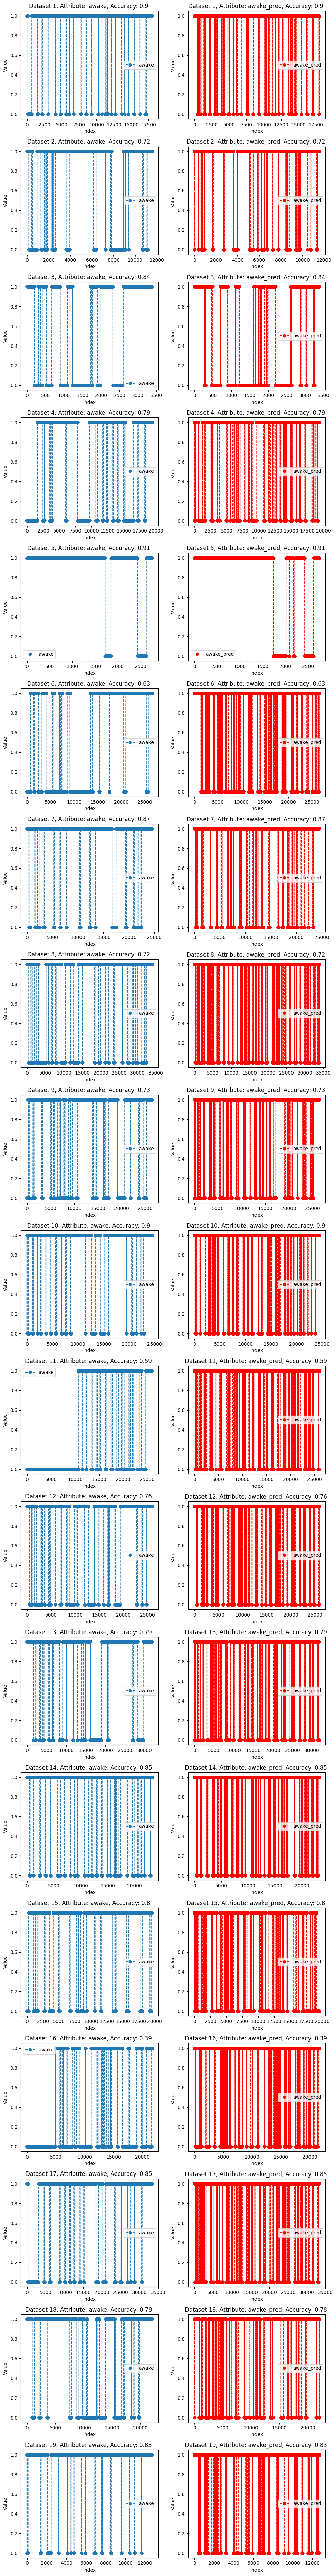

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed  # Your array with 18 datasets
selectedAttributes = ['awake','awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes  # Two subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        if(j % 2 == 1):
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o', color='red')
        else:
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}, Accuracy: {round(metricsAll[i]["accuracy"], 2)} ')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

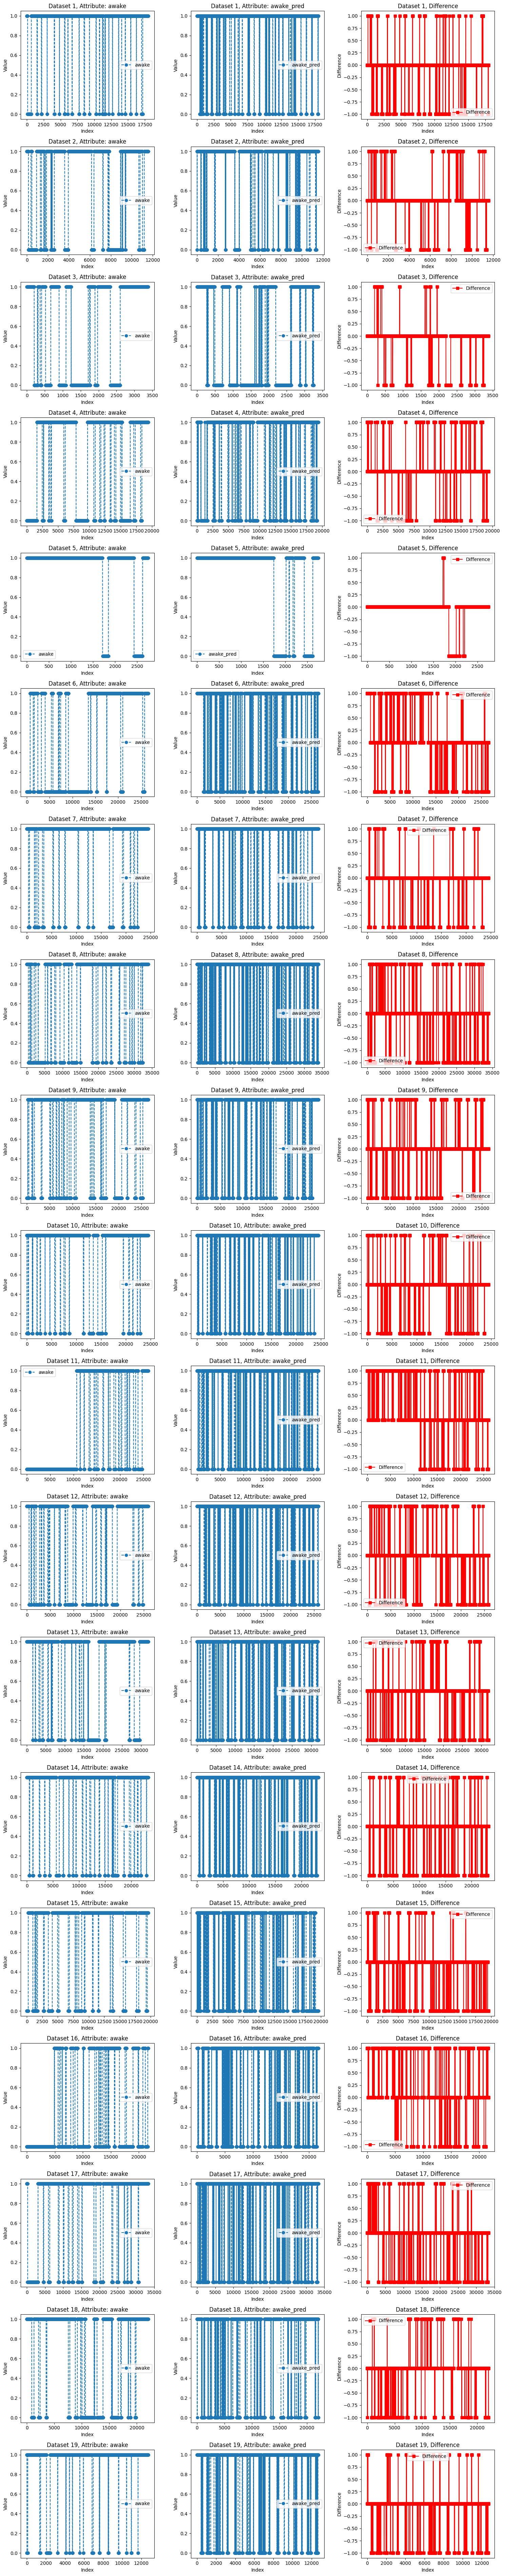

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed  # Your array with 18 datasets
selectedAttributes = ['awake', 'awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes + 1  # Three subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

    # Calculate and plot the difference between the selected attributes
    diff = dataset[selectedAttributes[1]] - dataset[selectedAttributes[0]]
    ax_diff = axs[i, num_attributes]  # Access the third subplot in the row
    ax_diff.plot(diff, label='Difference', linestyle='-', marker='s', color='red')
    ax_diff.set_title(f'Dataset {i+1}, Difference')
    ax_diff.set_xlabel('Index')
    ax_diff.set_ylabel('Difference')
    ax_diff.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
